In [ ]:
# Esta celda se ejecuta cuando el entorno es Google Colab. OJO: Ejecutar dos veces.

import os # Configura GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Reemplaza por "" para usar CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importar Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Instala Sionna en Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
# Esta celda se ejecuta en entorno local. OJO: No ejecutar en Google Colab.

import sionna

# Configura el notebook para usar un solo GPU y no reservar toda la memoria
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Evita log de errores de TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# Ploteo
%matplotlib inline
import matplotlib.pyplot as plt

2026-01-01 14:35:02.299536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-01 14:35:02.486118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767296102.554150   25021 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767296102.573929   25021 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767296102.724855   25021 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Parametros del sistema
sionna.phy.config.seed = 81 # semilla para reproducibilidad
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 1 # bits por símbolo (BPSK)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño de lote para ploteo
CRC="CRC24A" # tipo de CRC

I0000 00:00:1767296108.972872   25021 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9579 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
class SinCodigCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, bitsxsimb=bitsxsimb):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb) # para mas bpsimb usar "qam"
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = self.datos([batch_size, self.N])
        x = self.mapeador(b)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=coderate)
        h_real = sionna.phy.config.tf_rng.normal([batch_size], stddev=tf.sqrt(0.5), dtype=tf.float32)
        h_imag = sionna.phy.config.tf_rng.normal([batch_size], stddev=tf.sqrt(0.5), dtype=tf.float32)
        h = tf.complex(h_real, h_imag)
        y_pre = h[:, tf.newaxis] * x
        y = self.awgn(y_pre, no)

        # Ecualizador MMSE
        abs_h2 = tf.math.square(tf.abs(h))
        zf = tf.math.conj(h) / tf.cast(abs_h2 + no, tf.complex64)
        x_eq = zf[:, tf.newaxis] * y

        # Demapeo LLR
        no_eff = no / abs_h2
        llr = self.demapeador(x_eq, no_eff[:, tf.newaxis])

        return b, llr

In [4]:
# Se inicializa el sistema con los bits congelados aleatorios
sin_codigo = SinCodigCanalRayleigh(K, bitsxsimb=bitsxsimb) # 512 bits de datos

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.1654e-01 | 1.0000e+00 |       11087 |       51200 |          100 |         100 |         1.4 |reached target block errors
      1.0 | 2.0131e-01 | 1.0000e+00 |       10307 |       51200 |          100 |         100 |         0.0 |reached target block errors
      2.0 | 1.5828e-01 | 1.0000e+00 |        8104 |       51200 |          100 |         100 |         0.0 |reached target block errors
      3.0 | 1.4307e-01 | 9.9500e-01 |       14650 |      102400 |          199 |         200 |         0.1 |reached target block errors
      4.0 | 1.1680e-01 | 9.6500e-01 |       11960 |      102400 |          193 |         200 |         0.1 |reached target block errors
      5.0 | 1.1704e-01 | 9.5000e-01 |       11985 |      102400 |

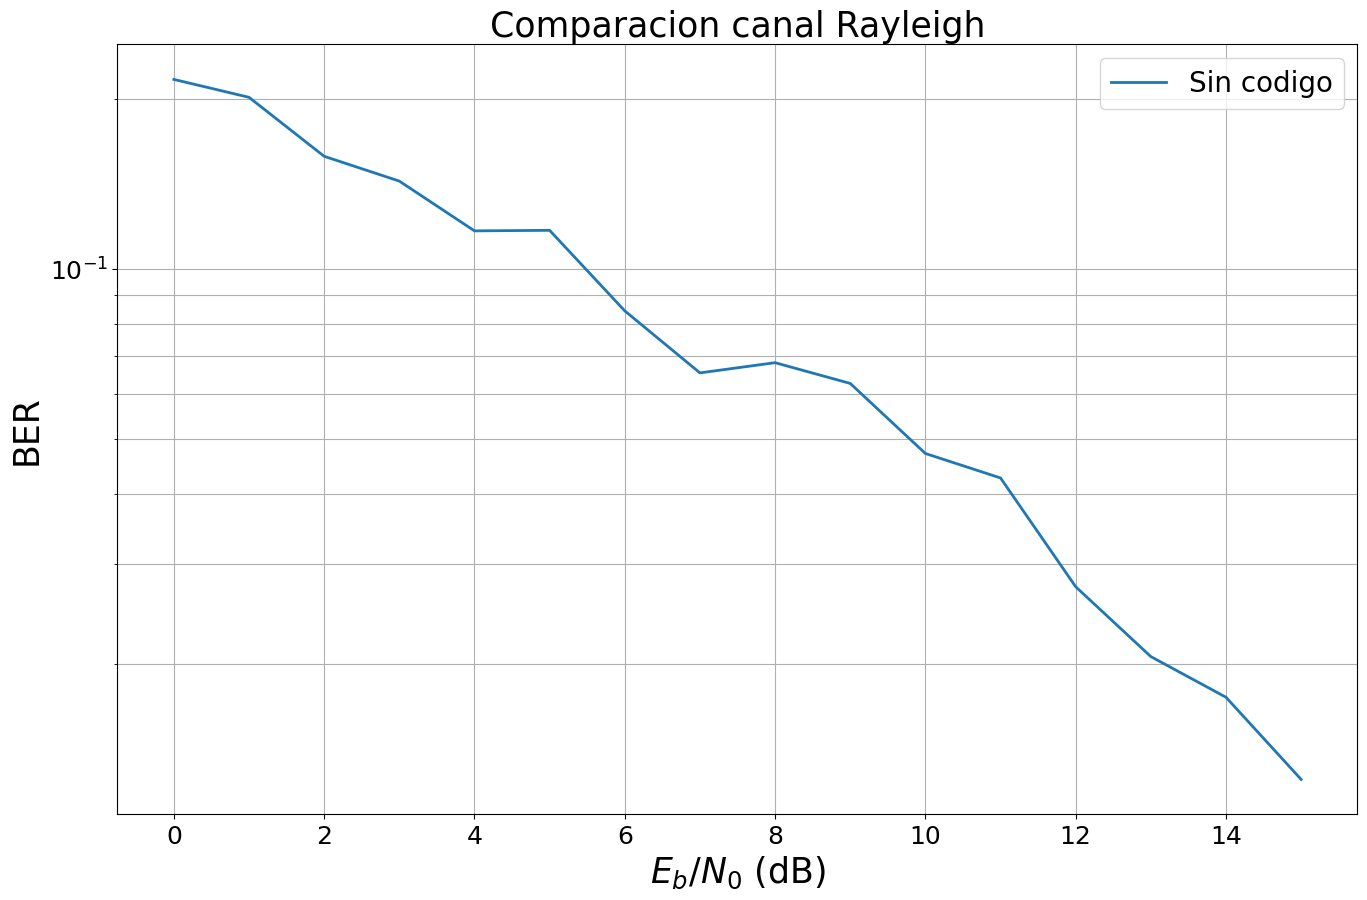

In [5]:
ber_plots = sionna.phy.utils.PlotBER("Comparacion canal Rayleigh")
ber_plots.simulate(sin_codigo,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [ ]:
## Generador Monte Carlo de bits congelados para canal Rayleigh

# Parámetros de la simulacion
# Recomendacion paper Sun y Zhang
simulaciones = 2000000
snr_prueba = 4.0
batch_size = 2000
num_batches = (simulaciones + batch_size - 1) // batch_size # En caso no divida exactamente
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=coderate)

# Inicializa los bloques necesarios
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)
awgn = sionna.phy.channel.AWGN()

for i in range(N):
    print(f"Procesando bit-canal {i+1}/{N}", end="", flush=True)

    # Se setean los bits congelados y reinicia conteo errores
    bits_congelados = np.array([j for j in range(N) if j != i]) # se analiza cada bit-canal
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1)
    errores_totales = 0
    bits_totales = 0

    # Se generan simulaciones sobre el canal Rayleigh    
    for b in range(num_batches):
        # Bloques de transmision
        bs = batch_size if (b < num_batches - 1) else (simulaciones - b*batch_size)
        bits = datos([bs, 1]) # solo 1 bit por muestra
        bits_codif = codificador(bits)
        x = mapeador(bits_codif)

        # Canal Rayleigh plano + AWGN
        h_real = sionna.phy.config.tf_rng.normal([batch_size], stddev=tf.sqrt(0.5), dtype=tf.float32)
        h_imag = sionna.phy.config.tf_rng.normal([batch_size], stddev=tf.sqrt(0.5), dtype=tf.float32)
        h_plano = tf.complex(h_real, h_imag)
        y_pre = h_plano[:, tf.newaxis] * x
        y = awgn(y_pre, no)

        # Ecualizador MMSE
        abs_h2 = tf.math.square(tf.abs(h_plano))
        mmse = tf.math.conj(h_plano) / tf.cast(abs_h2 + no, tf.complex64)
        x_eq = mmse[:, tf.newaxis] * y

        # Demapeo LLR
        no_eff = no / abs_h2
        llr = demapeador(x_eq, no_eff[:, tf.newaxis])
        bits_decodif = decodificador(llr)

        # Cálculo de errores
        err = tf.math.count_nonzero(tf.not_equal(bits, bits_decodif), dtype=tf.int32)
        errores_totales += int(err.numpy())
        bits_totales += bs  # porque bits es [bs,1] → 1 bit por muestra
        del bits, bits_codif, x, h_real, h_imag, h_plano, abs_h2, y_pre, y, mmse, x_eq, no_eff, llr, bits_decodif

    print()
    BER_bits[i] = errores_totales / bits_totales

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]


Procesando bit-canal 1/1024

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \



Procesando bit-canal 2/1024
Procesando bit-canal 3/1024
Procesando bit-canal 4/1024
Procesando bit-canal 5/1024
Procesando bit-canal 6/1024
Procesando bit-canal 7/1024
Procesando bit-canal 8/1024
Procesando bit-canal 9/1024
Procesando bit-canal 10/1024
Procesando bit-canal 11/1024
Procesando bit-canal 12/1024
Procesando bit-canal 13/1024
Procesando bit-canal 14/1024
Procesando bit-canal 15/1024
Procesando bit-canal 16/1024
Procesando bit-canal 17/1024
Procesando bit-canal 18/1024
Procesando bit-canal 19/1024
Procesando bit-canal 20/1024
Procesando bit-canal 21/1024
Procesando bit-canal 22/1024
Procesando bit-canal 23/1024
Procesando bit-canal 24/1024
Procesando bit-canal 25/1024
Procesando bit-canal 26/1024
Procesando bit-canal 27/1024
Procesando bit-canal 28/1024
Procesando bit-canal 29/1024
Procesando bit-canal 30/1024
Procesando bit-canal 31/1024
Procesando bit-canal 32/1024
Procesando bit-canal 33/1024
Procesando bit-canal 34/1024
Procesando bit-canal 35/1024
Procesando bit-canal 

In [7]:
# Sistema completo de codificación polar con canal Rayleigh
class CodPolarCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, CRC_tipo=CRC, lista_SCL=8, bitsxsimb=1):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        self.K = K
        self.K_datos = K - 24  # Asumiendo CRC24A
        self.bits_congelados = bits_congelados
        self.CRC_tipo = CRC_tipo
        self.lista_SCL = lista_SCL
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.CRC_codif = sionna.phy.fec.crc.CRCEncoder(CRC_tipo)
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
        self.constelacion = sionna.phy.mapping.Constellation("pam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=lista_SCL)
        self.CRC_decodif = sionna.phy.fec.crc.CRCDecoder(crc_encoder=self.CRC_codif)
        
    def call(self, batch_size, ebno_db):
        # Bloques de transmision
        b = self.datos([batch_size, self.K_datos])
        data_con_crc = self.CRC_codif(b)
        bits_codif = self.polar_codif(data_con_crc)
        x = self.mapeador(bits_codif)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=coderate)
        h_real = sionna.phy.config.tf_rng.normal([batch_size], stddev=tf.sqrt(0.5), dtype=tf.float32)
        h_imag = sionna.phy.config.tf_rng.normal([batch_size], stddev=tf.sqrt(0.5), dtype=tf.float32)
        h_plano = tf.complex(h_real, h_imag)
        y_pre = h_plano[:, tf.newaxis] * x
        y = awgn(y_pre, no)

        # Ecualizador MMSE
        abs_h2 = tf.math.square(tf.abs(h_plano))
        mmse = tf.math.conj(h_plano) / tf.cast(abs_h2 + no, tf.complex64)
        x_eq = mmse[:, tf.newaxis] * y

        # Demapeo LLR
        no_eff = no / abs_h2
        llr = demapeador(x_eq, no_eff[:, tf.newaxis])

        # Decodificación
        words_decodif = self.polar_decodif(llr)
        b_hat, crc_ok = self.CRC_decodif(words_decodif)
        
        return b, b_hat, llr, crc_ok

In [8]:
# Se inicializa el sistema con los bits congelados obtenidos por Monte Carlo para canal Rayleigh
cod_polar_rayleigh = CodPolarCanalRayleigh(N, K, bits_congelados, bitsxsimb=bitsxsimb)

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.3310e-01 | 7.0250e-01 |      130044 |      390400 |          562 |         800 |        57.9 |reached target block errors
      1.0 | 3.0349e-01 | 6.4000e-01 |      118482 |      390400 |          512 |         800 |        59.0 |reached target block errors
      2.0 | 2.6046e-01 | 5.5400e-01 |      127106 |      488000 |          554 |        1000 |        75.0 |reached target block errors
      3.0 | 2.2135e-01 | 4.7182e-01 |      118823 |      536800 |          519 |        1100 |        85.2 |reached target block errors
      4.0 | 1.8437e-01 | 3.9923e-01 |      116966 |      634400 |          519 |        1300 |        98.1 |reached target block errors
      5.0 | 1.4785e-01 | 3.1875e-01 |      115438 |      780800 |

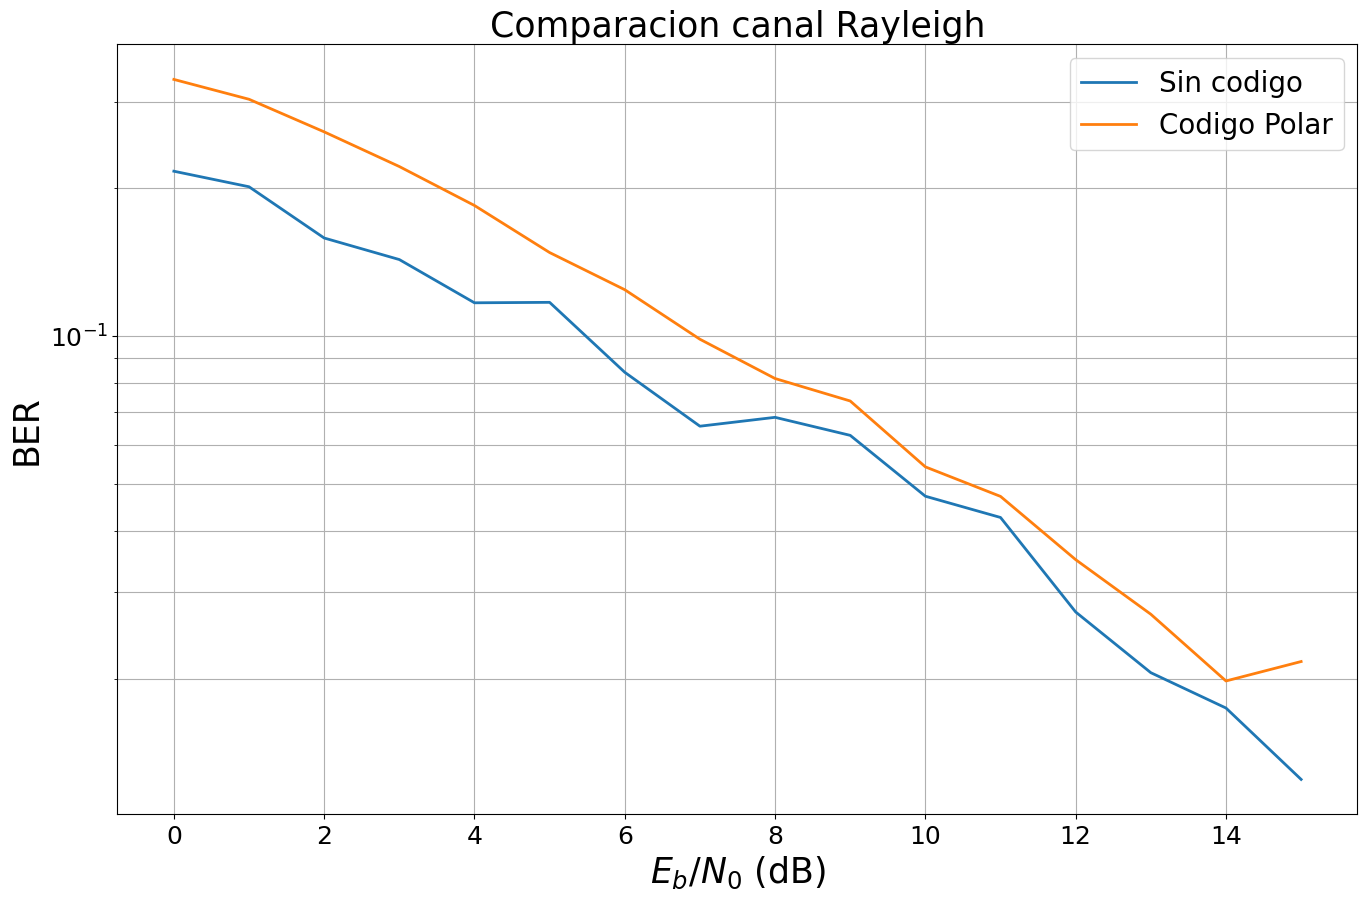

In [9]:
# Ploteo de la tasa de error para Rayleigh Polar
ber_plots.simulate(cod_polar_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Codigo Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);